In [1]:
## Every notebook should start with this header
# The next lines mean that changes in Python files are instantaneously applied
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from pathlib import Path

# As a sanity check, print out the current working directory
print(f"Running in {Path('').absolute()}")


import cfspopcon
import xarray as xr
from cfspopcon.named_options import AtomicSpecies
from cfspopcon.unit_handling import ureg
import numpy as np
import matplotlib.pyplot as plt

import extended_lengyel
plt.rcParams['mathtext.default'] = 'regular'

Running in /Users/tbody/Projects/extended-lengyel/notebooks


In [2]:
from extended_lengyel.extended_lengyel_model import LengyelModel

def run_lengyel_models(
    model: LengyelModel,
    override_elements = None,
    **overrides,
):
    algorithm = [
        "calc_target_electron_temp_from_cc_fit",
        "calc_upstream_field",
        "calc_cylindrical_edge_safety_factor",
        "calc_fieldline_pitch_at_omp",
        "set_radas_dir",
        "read_atomic_data",
        "set_single_impurity_species",
        "build_mixed_seeding_L_int_integrator",
        "calc_kappa_e0",
    ]

    match model:
        case LengyelModel.basic:
            algorithm += [
                "ignore_kappa_z",
                "calc_lambda_q_HD",
                "calc_parallel_heat_flux_density",
                "calc_separatrix_electron_temp_no_broadening",
                "calc_separatrix_total_pressure_LG",
                "calc_required_power_loss_fraction",
                "calc_parallel_heat_flux_at_target_from_power_loss_fraction",
                "run_basic_lengyel_model",
            ]
        case LengyelModel.S_correction:
            algorithm += [
                "ignore_kappa_z",
                "calc_lambda_q_HD",
                "calc_parallel_heat_flux_density",
                "ignore_power_loss_in_convection_layer",
                "ignore_temp_ratio_in_convection_layer",
                "calc_separatrix_electron_temp_with_broadening",
                "calc_separatrix_total_pressure_LG",
                "calc_required_power_loss_fraction",
                "calc_parallel_heat_flux_at_target_from_power_loss_fraction",
                "calc_parallel_heat_flux_from_conv_loss",
                "run_extended_lengyel_model_with_S_correction",
            ]
        case LengyelModel.S_Zeff_and_fconv_correction:
            algorithm += [
                "ignore_kappa_z",
                "calc_lambda_q_HD",
                "calc_parallel_heat_flux_density",
                "build_mixed_seeding_mean_charge_interpolator",
                "calc_power_loss_from_cc_fit",
                "calc_power_loss_from_cc_fit",
                "calc_electron_temp_from_cc_fit",
                "run_extended_lengyel_model_with_S_and_Zeff_correction",
            ]
        case LengyelModel.S_Zeff_fconv_and_alpha_t_correction:
            algorithm += [
                "build_mixed_seeding_mean_charge_interpolator",
                "calc_momentum_loss_from_cc_fit",
                "calc_power_loss_from_cc_fit",
                "calc_electron_temp_from_cc_fit",
                "run_extended_lengyel_model_with_S_Zeff_and_alphat_correction",
            ]
    
    algorithm += [
        "calc_sound_speed_at_target",
        "calc_target_density",
        "calc_flux_density_to_pascals_factor",
        "calc_parallel_to_perp_factor",
        "calc_ion_flux_to_target",
        "calc_divertor_neutral_pressure",
        "calc_radiative_efficiency",
        "calc_lambda_int_from_lambda_q",
        "calc_qdet_ext_7a",
        "calc_qdet_ext_7b",
        "calc_heat_flux_perp_to_target",
    ]

    algorithm = cfspopcon.CompositeAlgorithm.from_list(algorithm)

    
    ds = xr.Dataset(data_vars=extended_lengyel.read_config(
        elements        = ["base", "machine_geometry", "field_at_omp"] if override_elements is None else override_elements,
        keys            = algorithm.input_keys,
        allowed_missing = algorithm.default_keys,
        overrides       = overrides,
    ))

    algorithm.validate_inputs(ds)

    return algorithm.update_dataset(ds)

In [3]:
Lengyel_results = {
    LengyelModel.basic: "basic",
    LengyelModel.S_correction: "$+\\lambda_{INT}/\\lambda_q$",
    LengyelModel.S_Zeff_and_fconv_correction: "$+f_{conv}+\\kappa_z$",
    LengyelModel.S_Zeff_fconv_and_alpha_t_correction: "$+\\lambda_q(\\alpha_t)$"
}

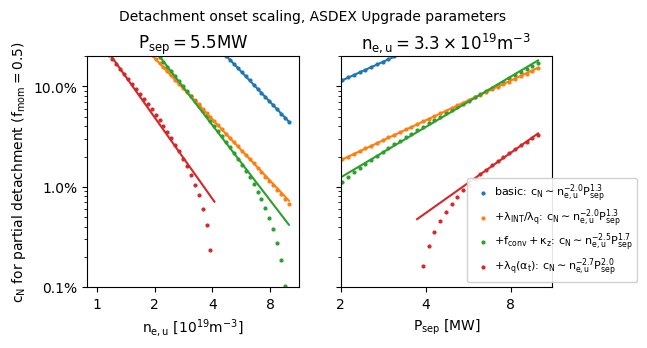

In [4]:
from enum import Enum, auto

class PlotVar(Enum):
    """Enum of possible atomic species."""

    impurity_fraction = auto()
    separatrix_electron_temp = auto()

import matplotlib.ticker as ticker
from cfspopcon.unit_handling import magnitude_in_units as mag

import extended_lengyel.directories

def power_law(x, m, b):
    return np.power(10, b) * np.power(x, m)

def plot_scalings(
    power_crossing_separatrix,
    separatrix_electron_density,
    selected_power_crossing_separatrix = 5.5 * ureg.MW,
    selected_separatrix_electron_density = 3.3 * ureg.n19,
    min_cz_for_fit = 1e-2,
    max_cz_for_fit = 1.0,
    plotvar = PlotVar.impurity_fraction,
):

    fig, axs = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)

    point_size = 4.0

    for C, (model, label) in enumerate(Lengyel_results.items()):
        
        fixed_power_ds = run_lengyel_models(
            power_crossing_separatrix   = selected_power_crossing_separatrix,
            separatrix_electron_density = separatrix_electron_density,
            model                       = model,
            plasma_current              = 0.8 * ureg.MA
        )
        fixed_density_ds = run_lengyel_models(
            power_crossing_separatrix   = power_crossing_separatrix,
            separatrix_electron_density = selected_separatrix_electron_density,
            model                       = model,
            plasma_current              = 0.8 * ureg.MA
        )

        for i, ds in enumerate([fixed_power_ds, fixed_density_ds]):
            
            ax = axs[i]

            if i == 0:
                x = mag(ds["separatrix_electron_density"], ureg.n19)
            elif i == 1:
                x = mag(ds["power_crossing_separatrix"], ureg.MW)

            if plotvar == PlotVar.impurity_fraction:
                y = mag(ds["impurity_fraction"], ureg.dimensionless)
                y_var = "c_N"

            elif plotvar == PlotVar.separatrix_electron_temp:
                y = mag(ds["separatrix_electron_temp"], ureg.eV)
                y_var = "T_{e,u}"

            y = y.broadcast_like(x)

            x = x.where(~np.isnan(y), drop=True)
            y = y.where(~np.isnan(y), drop=True)

            if plotvar == PlotVar.impurity_fraction:
                x_fit = x.where((y > min_cz_for_fit) & (y < max_cz_for_fit), drop=True)
                y_fit = y.where((y > min_cz_for_fit) & (y < max_cz_for_fit), drop=True)
            else:
                x_fit, y_fit = x, y

            if y_fit.size == 0:
                continue

            m, b = np.polyfit(np.log10(x_fit), np.log10(y_fit), 1)

            if i == 0:
                label = f"{label}: ${y_var}\\sim n_{{e,u}}^{{{m:.1f}}}"
                ax.scatter(x, y, s=point_size, c=f"C{C}")
                ax.plot(x, power_law(x, m, b), c=f"C{C}")
            else:
                ax.scatter(x, y, label=f"{label}P_{{sep}}^{{{m:.1f}}}$", s=point_size, c=f"C{C}")
                ax.plot(x, power_law(x, m, b), c=f"C{C}")

    axs[0].set_xlabel("$n_{e,u}$ [$10^{19}m^{-3}$]")
    axs[1].set_xlabel("$P_{sep}$ [$MW$]")
    axs[0].set_ylabel(f"${y_var}$ for partial detachment ($f_{{mom}}=0.5$)")
    axs[0].set_title(f"$P_{{sep}}={mag(selected_power_crossing_separatrix, ureg.MW):.1f}MW$")
    axs[1].set_title(f"$n_{{e,u}}={mag(selected_separatrix_electron_density, ureg.n19):.1f}\\times10^{{19}}m^{{-3}}$")

    for ax in axs:
        if plotvar == PlotVar.impurity_fraction:
            ax.set_xscale("log")
            ax.set_yscale("log")
            ax.set_xticks([], minor=True)
            ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
            ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
            ax.set_ylim(1e-3, 2e-1)

    plt.figlegend(loc="center",
                fontsize=8,
                labelspacing = 0.2,
                handletextpad=0.0,
                bbox_to_anchor=(0.9, 0.3),
                framealpha=0.9
    )
    axs[0].set_xticks([1, 2, 4, 8], minor=False)
    axs[1].set_xticks([2, 4, 8], minor=False)
    axs[1].set_xlim(left=2)

    fig.text(0.5, 1.0, "Detachment onset scaling, ASDEX Upgrade parameters", ha='center')
    
    return fig

fig = plot_scalings(
    separatrix_electron_density = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.n19, dims="separatrix_electron_density"),
    power_crossing_separatrix   = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.MW, dims="power_crossing_separatrix"),
)

fig.savefig(extended_lengyel.directories.output_dir / "detachment_onset_scaling.png", dpi=300, bbox_inches="tight")

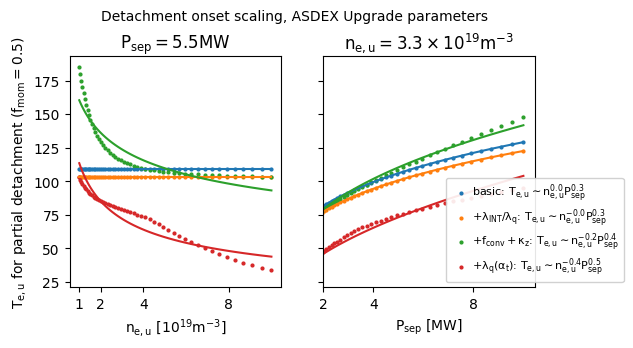

In [5]:
fig = plot_scalings(
    separatrix_electron_density = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.n19, dims="separatrix_electron_density"),
    power_crossing_separatrix   = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.MW, dims="power_crossing_separatrix"),
    plotvar                     = PlotVar.separatrix_electron_temp
)

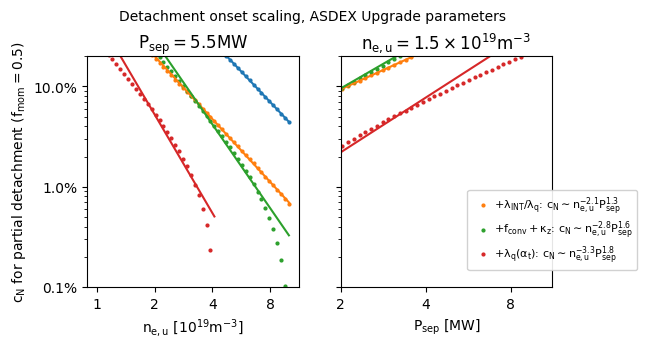

In [6]:
fig = plot_scalings(
    separatrix_electron_density          = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.n19, dims="separatrix_electron_density"),
    power_crossing_separatrix            = extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.MW, dims="power_crossing_separatrix"),
    selected_separatrix_electron_density = 1.5*ureg.n19,
    min_cz_for_fit                       = 0.5e-2,
    max_cz_for_fit                       = 1e-1
)

## Scaling to next-step devices

In [7]:
from cfspopcon.unit_handling import magnitude_in_units

print("SPARC PRD")
for atomic_species in [AtomicSpecies.Nitrogen, AtomicSpecies.Neon, AtomicSpecies.Argon]: 

    SPARC_PRD = run_lengyel_models(
        override_elements                           = [],
        SOL_momentum_loss_fraction                  = 0.5,
        power_crossing_separatrix                   = 25.0 * ureg.MW,
        separatrix_electron_density                 = 7.5 * ureg.n19,
        divertor_broadening_factor                  = 3.0,
        ion_mass                                    = 2.5 * ureg.amu,
        divertor_parallel_length                    = 15 * ureg.m,
        parallel_connection_length                  = 25 * ureg.m,
        major_radius                                = 1.85 * ureg.m,
        minor_radius                                = 0.57 * ureg.m,
        plasma_current                              = 8.7 * ureg.MA,
        magnetic_field_on_axis                      = 12.2 * ureg.T,
        elongation_psi95                            = 1.7,
        triangularity_psi95                         = 0.3,
        sheath_heat_transmission_factor             = 8.0,
        ratio_of_upstream_to_average_poloidal_field = 4/3,
        reference_ne_tau                            = 0.5 * ureg.ms * ureg.n20,
        fraction_of_P_SOL_to_divertor               = 2/3,
        target_angle_of_incidence                   = 3 * ureg.degree,
        model                                       = LengyelModel.S_Zeff_fconv_and_alpha_t_correction,
        impurity_species                            = atomic_species
    )

    print(f"Partial detachment with {magnitude_in_units(SPARC_PRD["impurity_fraction"].item(), "%"):.1f}% {atomic_species.name}")

    fz_cz = magnitude_in_units(
        SPARC_PRD["power_crossing_separatrix"] / SPARC_PRD["major_radius"] / SPARC_PRD["neutral_pressure_in_divertor"] * 5 * ureg.mm / SPARC_PRD["lambda_int"],
        ureg.MW / (ureg.m * ureg.Pa)).item() - 1
    fz = {
        AtomicSpecies.Nitrogen: 18,
        AtomicSpecies.Neon: 45,
        AtomicSpecies.Argon: 90,
    }[atomic_species]

    print(f"Kallenbach prediction {fz_cz / fz * 100:.1f}% {atomic_species.name}")

SPARC PRD
Partial detachment with 15.6% Nitrogen
Kallenbach prediction 15.5% Nitrogen
Partial detachment with 4.2% Neon
Kallenbach prediction 7.1% Neon
Partial detachment with 2.4% Argon
Kallenbach prediction 3.7% Argon


## Why is $c_z$ diverging at low values?

$\lambda_q$ is varying, but not enough to explain the large variation in $c_z$.

Text(0.5, 0, '$n_{e,u} [n_{19}]$')

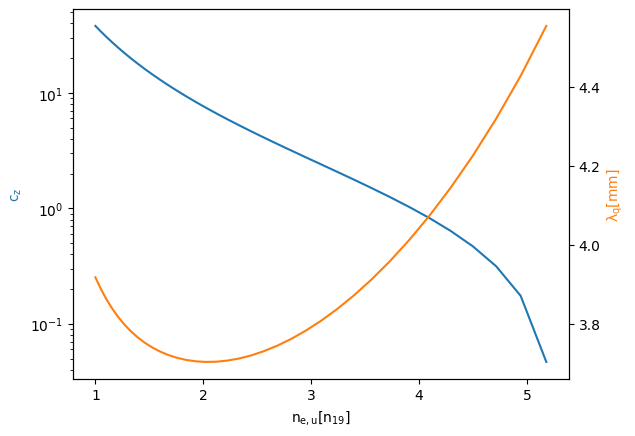

In [8]:
ds = run_lengyel_models(power_crossing_separatrix = 5.5 * ureg.MW,
                        separatrix_electron_density=extended_lengyel.promote_to_coordinate(np.logspace(np.log10(1), np.log10(10.0), num=50), ureg.n19, dims="separatrix_electron_density"),
                        model=LengyelModel.S_Zeff_fconv_and_alpha_t_correction)

fig, ax = plt.subplots()

ds["impurity_fraction"].plot(ax=ax, yscale="log")
ax.set_ylabel("$c_z$", color="C0")
ax2 = ax.twinx()

# ds["alpha_t"].where(~np.isnan(ds["impurity_fraction"])).plot(ax=ax2, color="C1")
# ax2.set_ylabel("$\\alpha_t$", color="C1")

mag(ds["lambda_q"], "mm").where(~np.isnan(ds["impurity_fraction"])).plot(ax=ax2, color="C1")
ax2.set_ylabel("$\\lambda_q [mm]$", color="C1")

ax.set_xlabel("$n_{e,u} [n_{19}]$")

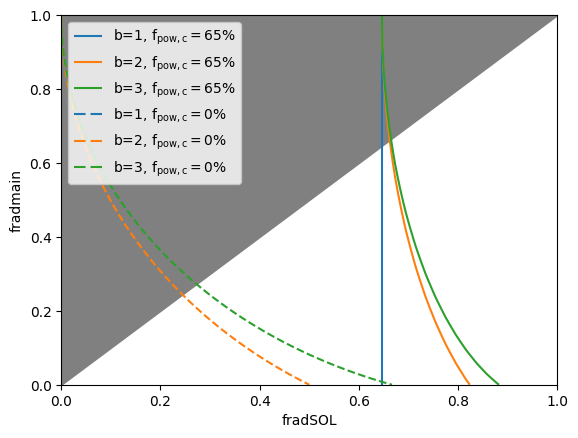

In [9]:
from extended_lengyel.extended_lengyel_model.convective_loss_fits import calc_target_electron_temp_from_cc_fit, calc_power_loss_from_cc_fit

target_electron_temp = calc_target_electron_temp_from_cc_fit(SOL_momentum_loss_fraction = 0.5)
fpowc = mag(calc_power_loss_from_cc_fit(target_electron_temp), "")

fradmain = xr.DataArray(x:=np.linspace(0, 1), coords=dict(fradmain=x))
fradSOL = xr.DataArray(x:=np.linspace(0, 1), coords=dict(fradSOL=x))

fig, ax = plt.subplots()
legend_elements = dict()

for linestyle, fpowc in zip(["-", "--"], [fpowc, 0.0]):
    for i, b in enumerate([1, 2, 3]):
        numerator = (1 + (1 / b**2 - 1)*(1-fradmain)**2 - (1-fradSOL)**2/(1-fpowc)**2)
        CS = numerator.plot.contour(levels=[0.0], colors=[f"C{i}"], linestyles=linestyle)
        legend_elements[f"b={b}, $f_{{pow,c}}={fpowc*100:.0f}\\%$"] = CS.legend_elements()[0][0]

ax.fill_between(fradmain, fradmain, 1, color="gray")
ax.legend(legend_elements.values(), legend_elements.keys())